# Resource competition: light and Fe in the Southern Ocean

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob

import xarray as xr
import numpy as np

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
import math

In [ ]:
ds = xr.concat((ds_DJF, ds_MAM, ds_JJA, ds_SON),'season')

In [15]:
ds.Fe_avg_50m

<xarray.DataArray 'Fe_avg_50m' (season: 4, time: 181, member_id: 34, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(4, 181, 34, 384, 320), dtype=float64, chunksize=(1, 181, 34, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Dimensions without coordinates: season, nlat, nlon
Attributes:
    long_name:     Fe avg in the top 50m
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [16]:
ds['season'] = ['DJF','MAM','JJA','SON'] 

In [17]:
ds

<xarray.Dataset>
Dimensions:          (member_id: 34, nlat: 384, nlon: 320, season: 4, time: 181, z_t: 60)
Coordinates:
  * time             (time) int64 1920 1921 1922 1923 ... 2097 2098 2099 2100
    TLAT             (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG            (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
  * member_id        (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * season           (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT              (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA            (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz               (season, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    Fe_avg_50m       (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    PAR_avg_50m      (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    diatC_50m_zint   (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    spC_50m_zint     (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    TEMP_50m_mean    (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    phytoC_50m_zint  (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>

### SIZ 2090s temp, original parameters

In [2]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = -0.028

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_SIZ = np.full((100,100),np.nan)
diat_growthrate_SIZ = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_SIZ[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_SIZ[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_SIZ = xr.DataArray(sp_growthrate_SIZ,dims=('par_vals','fe_vals'))
diat_growthrate_SIZ = xr.DataArray(diat_growthrate_SIZ,dims=('par_vals','fe_vals'))

### SIZ same alphas

In [10]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.34
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = -0.028

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_SIZ_same_alpha = np.full((100,100),np.nan)
diat_growthrate_SIZ_same_alpha = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_SIZ_same_alpha[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_SIZ_same_alpha[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_SIZ_same_alpha = xr.DataArray(sp_growthrate_SIZ_same_alpha,dims=('par_vals','fe_vals'))
diat_growthrate_SIZ_same_alpha = xr.DataArray(diat_growthrate_SIZ_same_alpha,dims=('par_vals','fe_vals'))

### SIZ, switch alphas

In [11]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.34
alpha_pi_sp = 0.3

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = -0.028

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_SIZ_switch_alpha = np.full((100,100),np.nan)
diat_growthrate_SIZ_switch_alpha = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_SIZ_switch_alpha[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_SIZ_switch_alpha[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_SIZ_switch_alpha = xr.DataArray(sp_growthrate_SIZ_switch_alpha,dims=('par_vals','fe_vals'))
diat_growthrate_SIZ_switch_alpha = xr.DataArray(diat_growthrate_SIZ_switch_alpha,dims=('par_vals','fe_vals'))

### ACC 2090s temp, original parameters

In [3]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = 7.

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_ACC = np.full((100,100),np.nan)
diat_growthrate_ACC = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_ACC[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_ACC[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_ACC = xr.DataArray(sp_growthrate_ACC,dims=('par_vals','fe_vals'))
diat_growthrate_ACC = xr.DataArray(diat_growthrate_ACC,dims=('par_vals','fe_vals'))

### try ACC 2090s temperature with diat alpha PI of 0.34 (same as sp)

In [ ]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.34
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = 7.

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_ACC_same_alpha = np.full((100,100),np.nan)
diat_growthrate_ACC_same_alpha = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_ACC_same_alpha[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_ACC_same_alpha[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_ACC_same_alpha = xr.DataArray(sp_growthrate_ACC_same_alpha,dims=('par_vals','fe_vals'))
diat_growthrate_ACC_same_alpha = xr.DataArray(diat_growthrate_ACC_same_alpha,dims=('par_vals','fe_vals'))

### Switch alpha -- so diatoms have the higher alpha

In [8]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.34
alpha_pi_sp = 0.3

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = 7.

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_ACC_switch_alpha = np.full((100,100),np.nan)
diat_growthrate_ACC_switch_alpha = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_ACC_switch_alpha[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_ACC_switch_alpha[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_ACC_switch_alpha = xr.DataArray(sp_growthrate_ACC_switch_alpha,dims=('par_vals','fe_vals'))
diat_growthrate_ACC_switch_alpha = xr.DataArray(diat_growthrate_ACC_switch_alpha,dims=('par_vals','fe_vals'))

### Plot it up:
row 1: original alphas (0.3 for diat, 0.34 for sp)

row 2: both sp and diat have an alpha of 0.34

row 3: switch alphas (0.34 for diat, 0.3 for sp)

## ACC

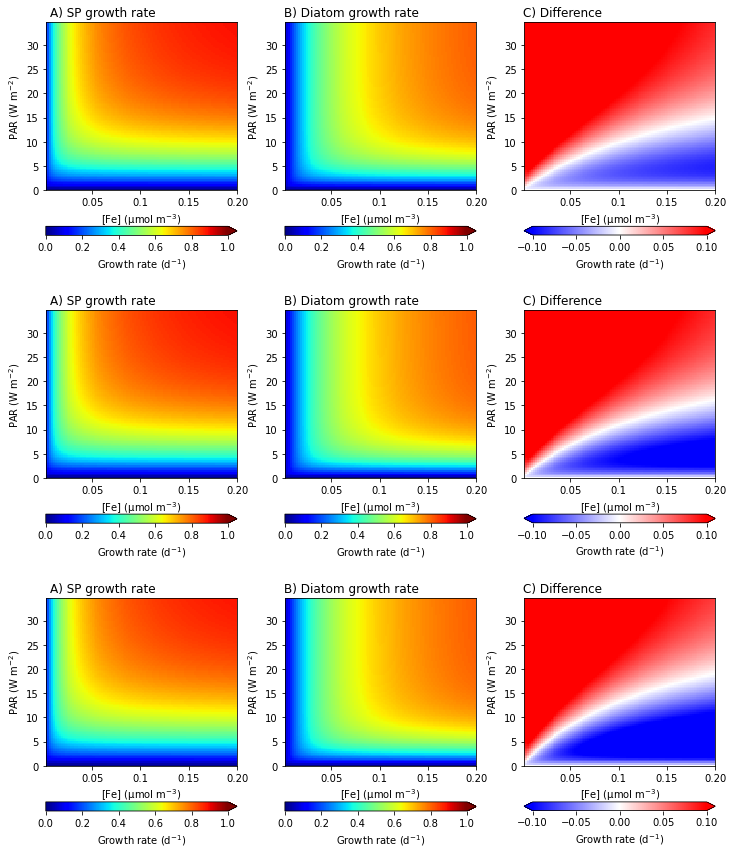

In [9]:
fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(3,3,1)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,2)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals, PAR_vals, diat_growthrate_ACC,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,3)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC-diat_growthrate_ACC,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

########################################## same alpha below

ax = fig.add_subplot(3,3,4)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC_same_alpha,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,5)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals, PAR_vals, diat_growthrate_ACC_same_alpha,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,6)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC_same_alpha-diat_growthrate_ACC_same_alpha,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

########################################## switch alpha below

ax = fig.add_subplot(3,3,7)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC_switch_alpha,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,8)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals, PAR_vals, diat_growthrate_ACC_switch_alpha,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,9)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC_switch_alpha-diat_growthrate_ACC_switch_alpha,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 



plt.subplots_adjust(wspace=0.25)

#fig.savefig('/glade/work/kristenk/figs/example_resource_comp.png', bbox_inches='tight', dpi=300, format='png');

## SIZ

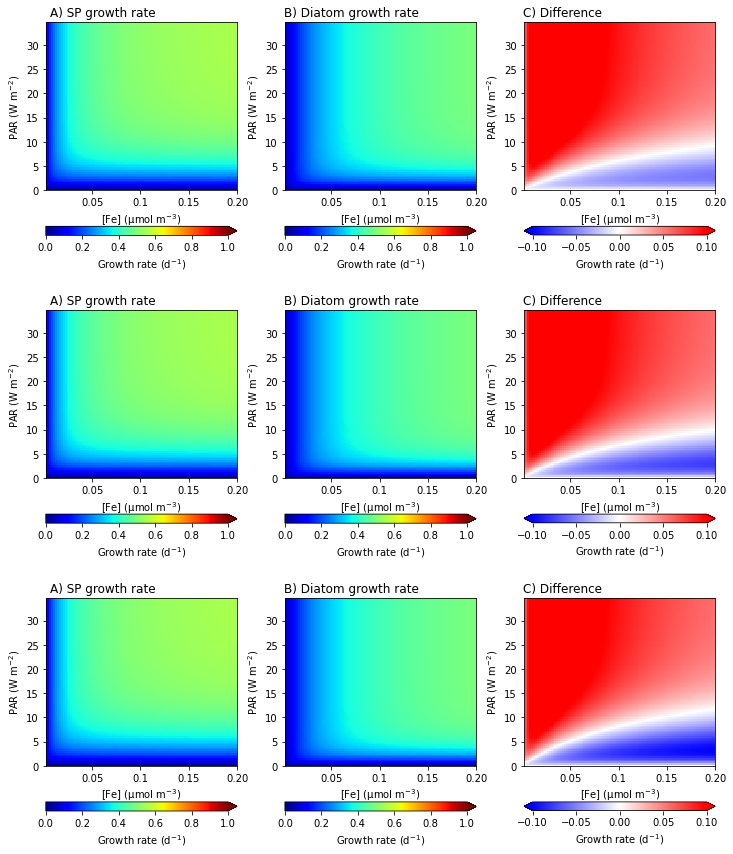

In [12]:
fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(3,3,1)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,2)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals, PAR_vals, diat_growthrate_SIZ,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,3)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ-diat_growthrate_SIZ,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

########################################## same alpha below

ax = fig.add_subplot(3,3,4)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ_same_alpha,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,5)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals, PAR_vals, diat_growthrate_SIZ_same_alpha,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,6)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ_same_alpha-diat_growthrate_SIZ_same_alpha,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

########################################## switch alpha below

ax = fig.add_subplot(3,3,7)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ_switch_alpha,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,8)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals, PAR_vals, diat_growthrate_SIZ_switch_alpha,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(3,3,9)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ_switch_alpha-diat_growthrate_SIZ_switch_alpha,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 



plt.subplots_adjust(wspace=0.25)

#fig.savefig('/glade/work/kristenk/figs/example_resource_comp.png', bbox_inches='tight', dpi=300, format='png');

### Summary figure for ACC and SIZ

In [21]:
## grab values for seasonal Fe and PAR from other notebook

ACC_Fe_2090vals = [0.00014981, 0.00012938, 0.00020404, 0.00023898]
ACC_PAR_2090vals = [30.74025025, 10.46632895,  4.22066327, 22.67584248]
SIZ_Fe_2090vals = [0.00011621, 0.00012481, 0.00021995, 0.00027421]
SIZ_PAR_2090vals = [22.78255669,  5.71994732,  0.3283335 ,  5.69467029]

ACC_Fe_1920vals = [0.00013736, 0.00011912, 0.00018796, 0.00022154]
ACC_PAR_1920vals = [32.44327199, 10.77240275,  4.50955436, 23.50404824]
SIZ_Fe_1920vals = [0.00014423, 0.00014033, 0.000238  , 0.0003027 ]
SIZ_PAR_1920vals = [14.42889776,  4.4218541 ,  0.07405806,  3.54660218]

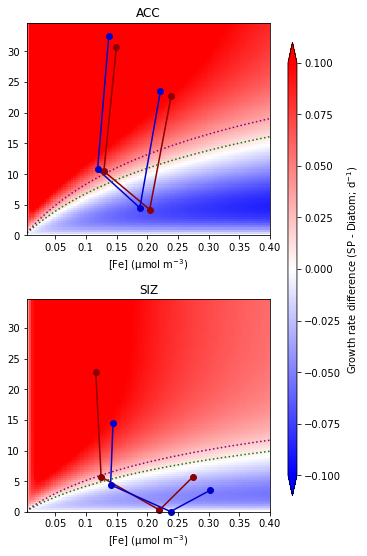

In [22]:
fig = plt.figure(figsize=(5,9))


ax = fig.add_subplot(2,1,1)
ax.set_title('ACC')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC-diat_growthrate_ACC,cmap='bwr',vmin=-0.1,vmax=0.1)
pci=ax.contour(Fe_vals, PAR_vals, sp_growthrate_ACC_same_alpha-diat_growthrate_ACC_same_alpha,levels=[0],colors='green',linestyles='dotted')
pci=ax.contour(Fe_vals, PAR_vals, sp_growthrate_ACC_switch_alpha-diat_growthrate_ACC_switch_alpha,levels=[0],colors='purple',linestyles='dotted')
#ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

# 
ax.scatter(ACC_Fe_2090vals,ACC_PAR_2090vals,
        marker='o',color='darkred',label='2090s',clip_on=False,zorder=2)
ax.plot(ACC_Fe_2090vals,ACC_PAR_2090vals,
        color='darkred',zorder=1)

ax.scatter(ACC_Fe_1920vals,ACC_PAR_1920vals,
        marker='o',color='mediumblue',label='2090s',clip_on=False,zorder=2)
ax.plot(ACC_Fe_1920vals,ACC_PAR_1920vals,
        color='mediumblue',zorder=1)

ax = fig.add_subplot(2,1,2)
ax.set_title('SIZ')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ-diat_growthrate_SIZ,cmap='bwr',vmin=-0.1,vmax=0.1)
pci=ax.contour(Fe_vals, PAR_vals, sp_growthrate_SIZ_same_alpha-diat_growthrate_SIZ_same_alpha,levels=[0],colors='green',linestyles='dotted')
pci=ax.contour(Fe_vals, PAR_vals, sp_growthrate_SIZ_switch_alpha-diat_growthrate_SIZ_switch_alpha,levels=[0],colors='purple',linestyles='dotted')
#ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

ax.scatter(SIZ_Fe_2090vals,SIZ_PAR_2090vals,
        marker='o',color='darkred',label='2090s',clip_on=False,zorder=2)
ax.plot(SIZ_Fe_2090vals,SIZ_PAR_2090vals,
        color='darkred',zorder=1)

ax.scatter(SIZ_Fe_1920vals,SIZ_PAR_1920vals,
        marker='o',color='mediumblue',label='2090s',clip_on=False,zorder=2)
ax.plot(SIZ_Fe_1920vals,SIZ_PAR_1920vals,
        color='mediumblue',zorder=1)

### color base
fig.subplots_adjust(right=0.8,wspace=0.1,hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (SP - Diatom; d$^{-1}$)');

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');